<a href="https://colab.research.google.com/github/gromanar/spark-py-nlp-tfm/blob/main/Spark_2_4_Spark_NLP_3_0_x_BERT_classification_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !cat /proc/cpuinfo

In [ ]:
GPU=True
if GPU:
  print("GPU Will be used")
  !nvidia-smi

GPU Will be used
Tue Jul 13 11:28:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
'''
para evitar que se ponga en off, hacer ctrol + shift + i y luego a consola
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''

'\npara evitar que se ponga en off, hacer ctrol + shift + i y luego a consola\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [ ]:
!lsb_release -a
# !wget http://setup.johnsnowlabs.com/colab.sh && cat colab.sh

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [ ]:
print( "setup Colab para PySpark y Spark NLP ")
!apt-get update
!apt-get purge -y openjdk-11* -qq > /dev/null && sudo apt-get autoremove -y -qq > /dev/null
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

setup Colab para PySpark y Spark NLP 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.2 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]

In [ ]:
# !conda create -n sparknlp python=3.7 -y
!conda activate sparknlp
# !pip install spark-nlp==3.0.2 pyspark==3.1.1 # para spark 3 pero no tira
!pip install spark-nlp==3.0.3 pyspark==2.4.7


/bin/bash: conda: command not found
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 217.9MB 57kB/s 
     |████████████████████████████████| 204kB 20.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279468 sha256=6036ebb3183fdcfd74002548188ce6868bbc676a02df8ced47cdf6bca9cb3fa3
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark


In [ ]:
# export SPARK_HOME=$SPARKHOME
# export JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

# # Install pyspark spark-nlp
# ! pip install --upgrade -q pyspark==$PYSPARK spark-nlp==$SPARKNLP findspark

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
# spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

# para las puntuaciones
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import time
inicio = time.time()

In [ ]:
# from pyspark.sql import SparkSession
# choose gpu/cpu 
if GPU:
  #sparknlp="com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:3.0.2"
  sparknlp="com.johnsnowlabs.nlp:spark-nlp-gpu-spark24_2.11:3.0.3"
else:
  #sparknlp="com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.2"
  sparknlp="com.johnsnowlabs.nlp:spark-nlp-spark24_2.11:3.0.3"
spark = (SparkSession.builder
              .master("local[*]")
              .appName("Spark NLP Classification")
              .config("spark.driver.memory","10G")  # maximo 12
              .config("spark.driver.maxResultSize", "0") 
              .config("spark.kryoserializer.buffer.max", "2000M")
              .config("spark.jars.packages", sparknlp)
              .getOrCreate()
   )
spark

In [ ]:
import sparknlp
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.0.3
Apache Spark version: 2.4.7


Crear funciones propias y ejecutandolas con `UDF` de pyspark.sql.functions

# 1. Read data

### download data

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv -P ./sample_data -q
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_test.csv -P ./sample_data -q

In [ ]:
!ls ./sample_data

anscombe.json		      mnist_test.csv	      news_category_train.csv
california_housing_test.csv   mnist_train_small.csv   README.md
california_housing_train.csv  news_category_test.csv


In [ ]:

# Si queremos hacer el split al dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

'\n(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)\nprint("Training Dataset Count: " + str(trainingData.count()))\nprint("Test Dataset Count: " + str(testData.count()))\n'

In [ ]:
root_folder = "./sample_data/"
traindata = root_folder + "news_category_train.csv"
testdata = root_folder + "news_category_test.csv"

In [ ]:
trainDataset = spark.read \
      .option("header", True) \
      .csv(traindata)
trainDataset.show(10, truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
|Business| Stocks ended slightly higher on Friday but sta...|
|Business| Assets of the nation's retail money market mut...|
|Business| Retail sales bounced back a bit in July, and n...|
|Business|" After earning a PH.D. in Sociology, Danny Baz...|
|Business| Short sellers, Wall Street's dwindling  band o...|
+--------+--------------------------------------------------+
only showing top 10 rows



# 2. Explore data

In [ ]:
print("el numero de particiones es: ",trainDataset.rdd.getNumPartitions())
# Let's do a full-shuffle with the repartition method and get this data on two nodes.
trainDataset = trainDataset.repartition(200)
print("el numero de particiones despues de la reparticion es (a parTe que se ha hecho fullsuffle) : ",trainDataset.rdd.getNumPartitions())

el numero de particiones es:  2
el numero de particiones despues de la reparticion es (a parTe que se ha hecho fullsuffle) :  200


In [ ]:
from pyspark.sql.functions import col
trainDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()


+--------+-----+
|category|count|
+--------+-----+
|   World|30000|
|  Sports|30000|
|Sci/Tech|30000|
|Business|30000|
+--------+-----+



# 3. Create Test

In [ ]:
testDataset = spark.read \
      .option("header", True) \
      .csv(testdata)
testDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|   World| 1900|
|Sci/Tech| 1900|
|  Sports| 1900|
|Business| 1900|
+--------+-----+



## CONFIGURACIÓN DE LOS MODELOS PREENTRENADOS BERT

>CONSULTAR LOS MODELOS PREENTRENADOS DISPONIBLES [AQUI](https://nlp.johnsnowlabs.com/models)



In [ ]:
def experimento(tipo: str, idioma: str):
  if tipo.upper()=="A":
    BATCH_SIZE = 16
    EPOCHS = 2
    LEARNING_RATE = 5e-5
  elif tipo.upper()=="B":
    BATCH_SIZE = 32
    EPOCHS = 4
    LEARNING_RATE = 3e-5
  else:
      print("elige experimento")
  
  if idioma.upper()=="EN":
    PRE_TRAINED_MODEL_NAME = 'small_bert_L4_256'
  elif idioma.upper()=="ES":
    PRE_TRAINED_MODEL_NAME = 'bert_multi_cased'
  else:
    print("modelo no elegido")
  return BATCH_SIZE, EPOCHS, LEARNING_RATE,PRE_TRAINED_MODEL_NAME

BATCH_SIZE, EPOCHS, LEARNING_RATE, PRE_TRAINED_MODEL_NAME = experimento(tipo = "a", idioma ="en")


SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_'+PRE_TRAINED_MODEL_NAME

# Original values
# PRE_TRAINED_MODEL_NAME = 'bert_base_cased' # 389.1 MB
# PRE_TRAINED_MODEL_NAME = 'sent_small_bert_L8_512' 149.1 MB
# PRE_TRAINED_MODEL_NAME = 'small_bert_L4_256' 40.5 MB

# Para sentence embeddings.
# SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_bert_base_cased'
# SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_small_bert_L8_512' # 149.1 MB


# set learning rate 
# learning_rate = 0.001
# learning_rate = 2e-5




# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

In [ ]:
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"EPOCHS: {EPOCHS}")
print(f"PRE_TRAINED_MODEL_NAME: {PRE_TRAINED_MODEL_NAME}")
print(f"PRE_TRAINED_MODEL_NAME FOR SENTENCES: {SENTENCE_PRE_TRAINED_MODEL_NAME}")

BATCH_SIZE: 16
LEARNING_RATE: 5e-05
EPOCHS: 2
PRE_TRAINED_MODEL_NAME: small_bert_L4_256
PRE_TRAINED_MODEL_NAME FOR SENTENCES: sent_small_bert_L4_256


# 4. Clasificación de textos usando BERT EMBEDDINGS

Naming conventions in Spark NLP Bert models. L indicates which pooling layer is used while producing the embeddings and H mean the dimension of the embeddings returned. 

L indica que pooling layer se usa mientras se producen las ingestas y 
H significa la dimensión que se devuelve de esos embeddings

[ver lista](https://github.com/JohnSnowLabs/spark-nlp-models)

- utilizamos `BertSentenceEmbeddings` == `'sent_small_bert_L8_512'`

  Simplemente cargamos `Bert Sentence Embeddings Small` con dimensión L8 y 512 y usamos eso en lugar de USE. Como puede ver, es casi 8 veces más pequeño que el tamaño de USE con el poder de Bert. 

El modelo se puede utilizar de manera offline si se desea, pero habria que descargarlo previamente.

De esta manera dejamos a SPARK_NLP que lo baje automáticamente.




In [ ]:
(time.time() - inicio)/60

0.8036699533462525

**BERT EMBEDDINGS**

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# BertEmbeddings utiliza los datos de una red neuronal entrenada previamente (el nombre del modelo) para crear codificar las palabras que contiene cada texto 
# convirtiendo a vectores dichas palabras. (codificandolas) AQUI USE AL PRINCIPIO 'small_bert_L4_256'
bert_embeddings = BertEmbeddings().pretrained(name=PRE_TRAINED_MODEL_NAME, lang='en') \
    .setInputCols(["document",'token'])\
    .setOutputCol("embeddings")
#
embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")
# ClassifierDLApproach: ClassifierDL Utiliza el State-of-the-art de las Universal Sentence Encoder como input para iniciar clasificaciones de texto.
# es un clasificador que contiene casi 100 clases de tensorflow, usa modelos de deep learning DNN
# LR 5e-3f BATCHSIZE 8
classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("category")\
    .setMaxEpochs(EPOCHS)\
    .setLr(LEARNING_RATE)\
    .setBatchSize(BATCH_SIZE)\
    .setEnableOutputLogs(True)
    #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    bert_embeddings,
    embeddingsSentence,
    classsifierdl
])


small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


## 4.1 Ajuste del modelo (FIT)

In [ ]:
%%time
bert_Model = bert_clf_pipeline.fit(trainDataset) # +25 min # inicio = time.time()
# sin particioNar
# CPU times: user 24.8 s, sys: 2.79 s, total: 27.6 s
# Wall time: 1h 15min 58s
# GPU
# CPU times: user 4.18 s, sys: 451 ms, total: 4.64 s
# Wall time: 17min 50s

CPU times: user 4.18 s, sys: 451 ms, total: 4.64 s
Wall time: 17min 50s


In [ ]:
(time.time() - inicio)/60
# bert_Model.withColumn("tmp", F.explode("chunk")).select("tmp.*")

19.236742508411407

## 4.2 realizamos predicciones en el conjunto de prueba 

In [ ]:
# prueba ligera
light_model = LightPipeline(bert_Model)

light_result = light_model.annotate("John and Peter are brothers. However they don't support each other that much.")
print(light_result)

{'document': ["John and Peter are brothers. However they don't support each other that much."], 'sentence_embeddings': ["John and Peter are brothers. However they don't support each other that much."], 'token': ['John', 'and', 'Peter', 'are', 'brothers', '.', 'However', 'they', "don't", 'support', 'each', 'other', 'that', 'much', '.'], 'class': ['Sports'], 'embeddings': ['john', 'and', 'peter', 'are', 'brothers', '.', 'however', 'they', "don't", 'support', 'each', 'other', 'that', 'much', '.']}


In [ ]:
predict_bert = bert_Model.transform(testDataset)

predict_bert.select("category","description","class.result").show(10,truncate=80)

+--------+--------------------------------------------------------------------------------+----------+
|category|                                                                     description|    result|
+--------+--------------------------------------------------------------------------------+----------+
|Business|Unions representing workers at Turner   Newall say they are 'disappointed' af...|[Business]|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 mil...|[Sci/Tech]|
|Sci/Tech| A company founded by a chemistry researcher at the University of Louisville ...|[Sci/Tech]|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts his shift with a blur of color...|[Sci/Tech]|
|Sci/Tech| Southern California's smog fighting agency went after emissions of the bovin...|[Business]|
|Sci/Tech|"The British Department for Education and Skills (DfES) recently launched a "...|[Sci/Tech]|
|Sci/Tech|"confessed author of the Netsky and Sasser viruses, is responsi

In [ ]:
(time.time() - inicio)/60

19.269484651088714

## 4.3 Obtenemos el rendimiento del modelo para comparar con la opcion de USE


In [ ]:
df=bert_Model.transform(testDataset).select("category","description","class.result").toPandas()
# extraemos el resultado de la lista
df.result=df.result.apply(lambda x: x[0])

print(classification_report(df.category, df.result))
print(accuracy_score(df.category, df.result))

              precision    recall  f1-score   support

    Business       0.80      0.78      0.79      1900
    Sci/Tech       0.80      0.83      0.81      1900
      Sports       0.92      0.94      0.93      1900
       World       0.87      0.84      0.86      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

0.8481578947368421


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# df["category_encoded"]=le.fit_transform(df.category)
# df_testdata["category_encoded"]=le.fit_transform(df_testdata.category)
class_names=trainDataset.groupBy("category").count().select("category").rdd.flatMap(lambda x: x).collect()
class_names.sort()
class_names

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8



def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True category')
  plt.xlabel('Predicted category');



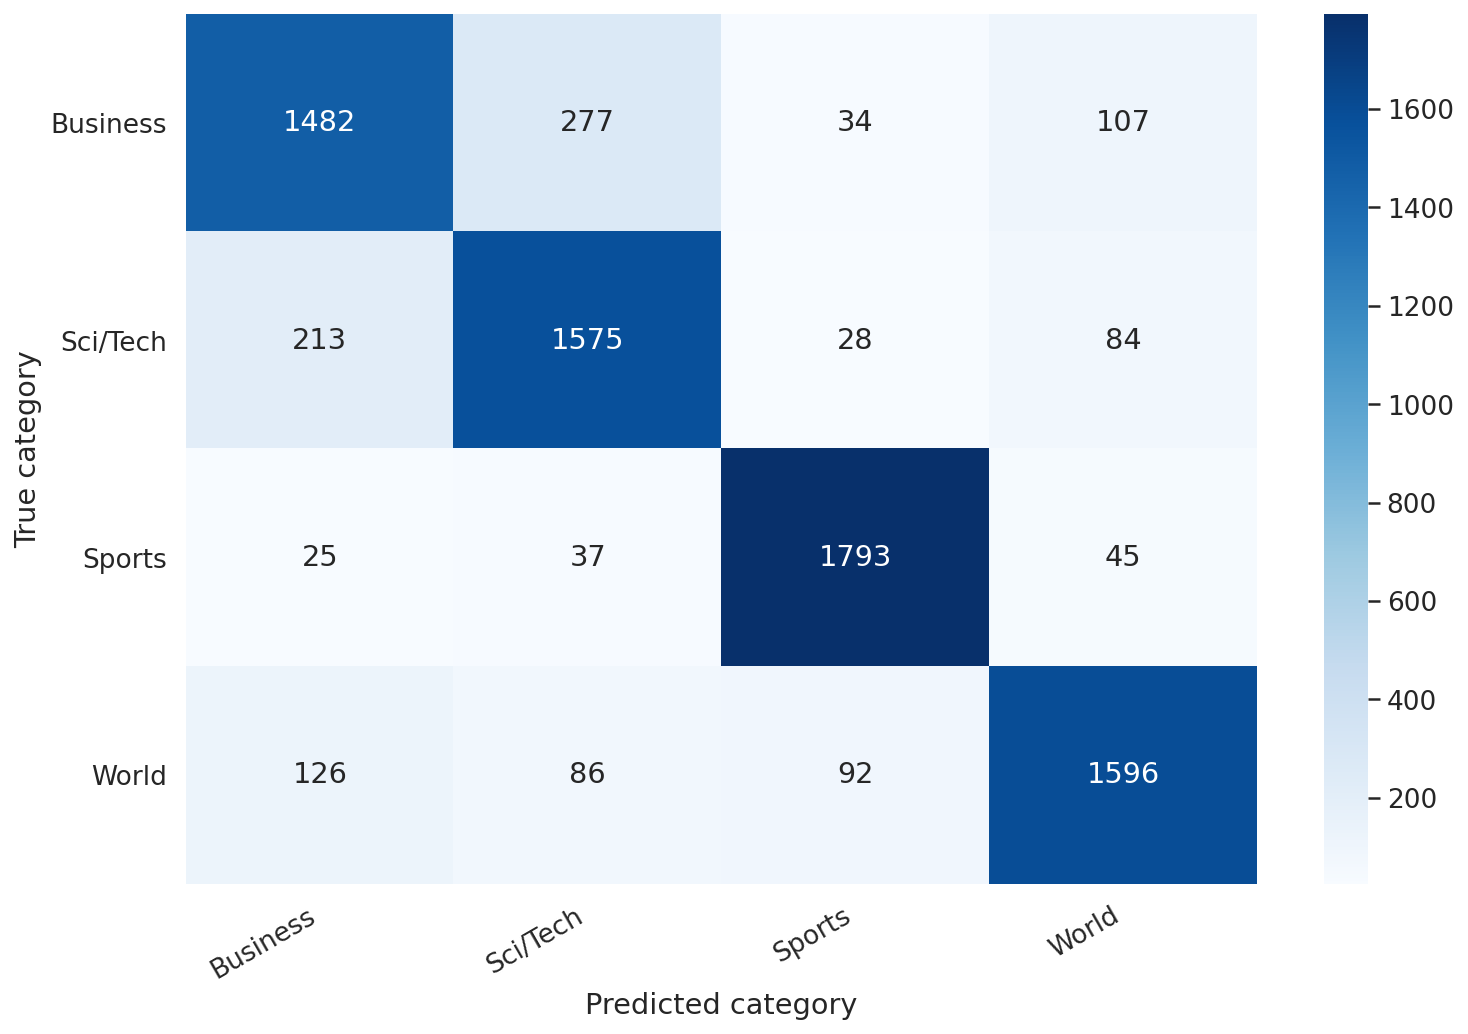

In [ ]:
cm = confusion_matrix(df.category, df.result)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 5. BERT SENTENCE EMBEDDINGS CLASsIFICATION MODEL


In [ ]:
# actual content is inside description column
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")


# we can also use sentece detector here if we want to train on and get predictions for each sentence
# las palabras o frases del lenguaje natural son representadas como vectores
bert_sent = BertSentenceEmbeddings.pretrained(SENTENCE_PRE_TRAINED_MODEL_NAME)\
      .setInputCols(["document"])\
      .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
# MAX EPOCHS IN THIS WAS 10
classsifierdl = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("category")\
      .setMaxEpochs(EPOCHS)\
      .setEnableOutputLogs(True)\
      .setLr(LEARNING_RATE)\
      .setBatchSize(BATCH_SIZE)

bert_sent_clf_pipeline = Pipeline(
    stages = [
        document_assembler,
        bert_sent,
        classsifierdl
    ])

sent_small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [ ]:
%%time
bert_sent_pipelineModel = bert_sent_clf_pipeline.fit(trainDataset)
# GPU
# CPU times: user 2.67 s, sys: 300 ms, total: 2.97 s
# Wall time: 12min 27s

CPU times: user 2.67 s, sys: 300 ms, total: 2.97 s
Wall time: 12min 27s


In [ ]:
# We are going to use sklearn to evalute the results on test dataset Usamos sklearn para eValuar los resultados en el conjunto de datos de prueba.
from sklearn.metrics import classification_report

preds = bert_sent_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print(classification_report(preds_df.category, preds_df.result))
print(accuracy_score(preds_df['category'], preds_df['result']))

              precision    recall  f1-score   support

    Business       0.79      0.78      0.78      1920
    Sci/Tech       0.81      0.80      0.80      1931
      Sports       0.94      0.92      0.93      1946
       World       0.84      0.88      0.86      1803

    accuracy                           0.84      7600
   macro avg       0.84      0.85      0.84      7600
weighted avg       0.85      0.84      0.84      7600

0.8448684210526316


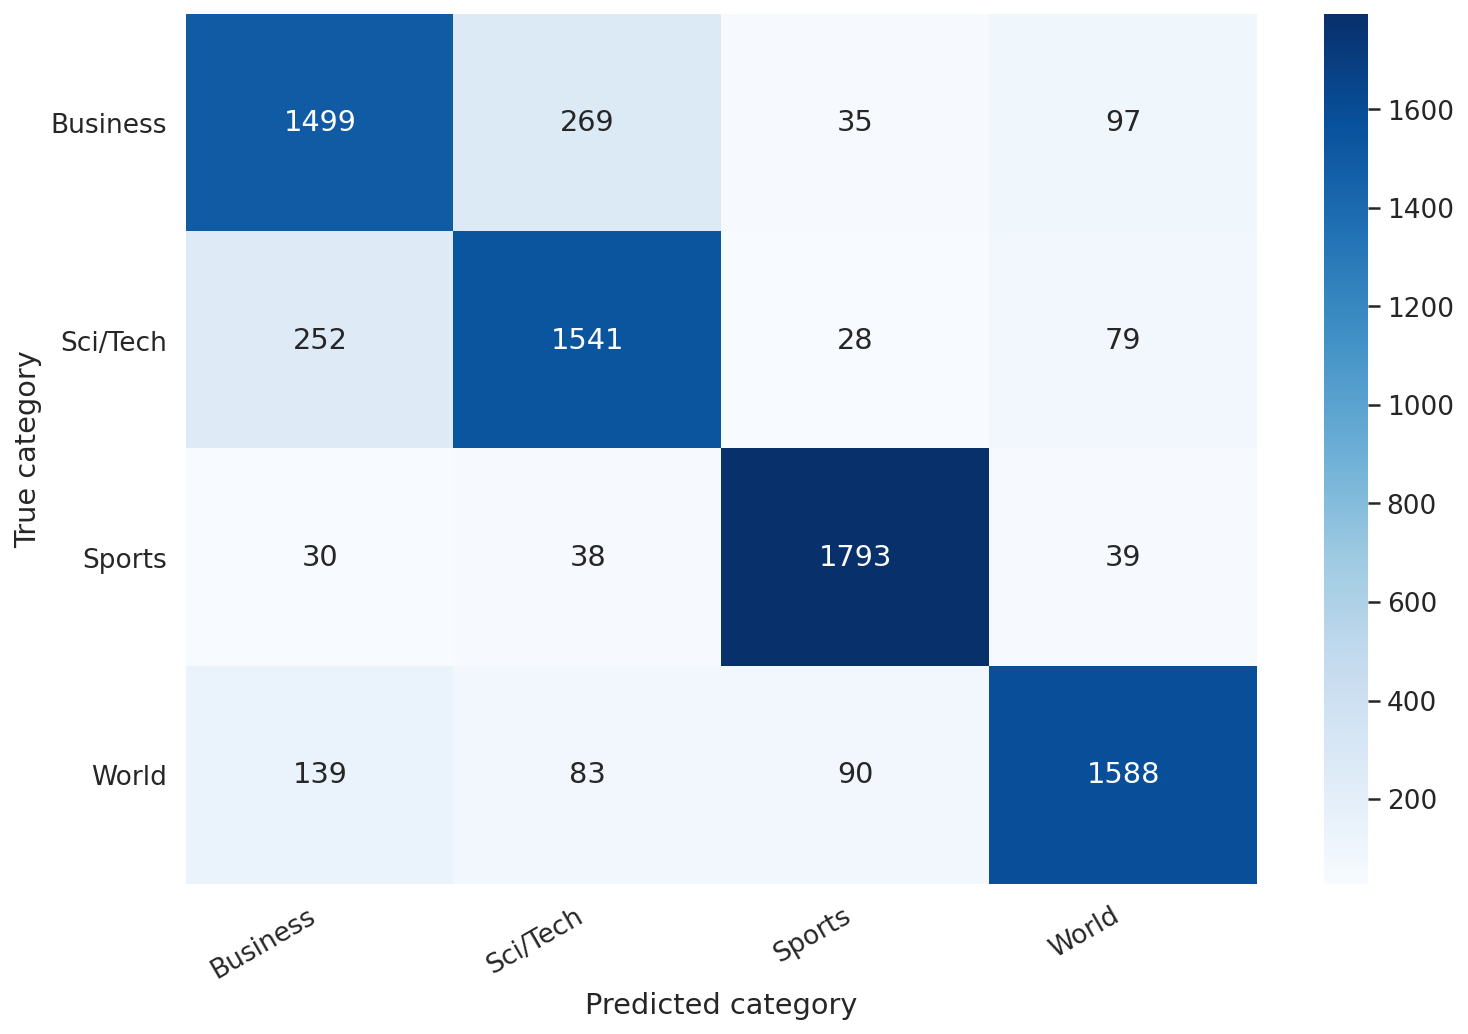

In [ ]:
cm = confusion_matrix(preds_df.category, preds_df.result)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**TOMAMOS PREDICCION DEL MODELO**

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(bert_sent_pipelineModel)

In [ ]:
testDataset.select('description').take(2)

[Row(description="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(description=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.')]

In [ ]:
text='''
Fearing the fate of Italy, the centre-right government has threatened to be merciless with those who flout tough restrictions. 
As of Wednesday it will also include all shops being closed across Greece, with the exception of supermarkets. Banks, pharmacies, pet-stores, mobile phone stores, opticians, bakers, mini-markets, couriers and food delivery outlets are among the few that will also be allowed to remain open.
'''
result = light_model.annotate(text)

result['class']

['Business']

In [ ]:
light_model.annotate('the soccer games will be postponed.')

{'class': ['Sports'],
 'document': ['the soccer games will be postponed.'],
 'sentence_embeddings': ['the soccer games will be postponed.']}

In [ ]:
light_model.annotate(
    "Cristiano Ronaldo has become the best student of the month"
)["class"]

['Sports']

# Pipeline COMPLETO de clasificación con ML 

Ahora vamos a aplicar ese modelo, realizando un poquito de preprocesado para los datos.



1.   Creamos el corpus para el input del modelo
2.   tokenizamos.
3.   normalizamos.
4.   quitamos stopwords (palabras que no aportan información)
5.   lemmatizer, busca la paplabra raiz, se diferencia del stemmer a que no recorta la palabra hasta quitarle el sentido. books --> book 
6.   word embeddings no se
7.   sentence embeddings no se
8.   clasificador





In [ ]:
# doccument_assembler = DocumentAssembler()\
#       .setInputCol("text")\
#       .setOutputCol("document")

# tokenizer = Tokenizer()\
#       .setInputCols(["document"])\
#       .setOutputCol("token")

# normalizer = Normalizer()\
#       .setInputCols(["token"])\
#       .setOutputCol("normalized")

# stopwords_cleaner = StopWordsCleaner()\
#       .setInputCols(["normalized"])\
#       .setOutputCol("cleanTokens")\
#       .setCaseSensitive(False)
  
# lemma = LemmatizerModel.pretrained("lemma_antbnc")\
#       .setInputCols(["cleanTokens"])\
#       .setOutputCol("lemma")

# #  en lugar de usar embeddings USE podemos usar el bert, que es el que usarmemos en el modelo final.
# word_embeddings_use = WordEmbeddingsModel().pretrained()\
#       .setInputCols(["document","lemma"])\
#       .setOutputCol("embeddings")

# # este modelo --> 'bert_base_cased' para realizar el embeddings pesa bastante, quiza buscar uno mas peq.
# word_embeddings_bert = BertEmbeddings\
#     .pretrained(PRE_TRAINED_MODEL_NAME, 'en') \
#     .setInputCols(["document",'lemma'])\
#     .setOutputCol("embeddings")\

# # al igual que en las frases

# embeddingsSentence = (SentenceEmbeddings()                   
#                    .setInputCols(["document","embeddings"])
#                    .setOutputCol("sentence_embeddings")
#                    .setPoolingStrategy('AVERAGE')
#                    )
# # este era el modelo para crear las sentence embeddings con BERT 'sent_small_bert_L8_512'
# embeddingsSentence_bert = (BertSentenceEmbeddings
#                    .pretrained(SENTENCE_PRE_TRAINED_MODEL_NAME)
#                    .setInputCols(["document","embeddings"])
#                    .setOutputCol("sentence_embeddings"))


# classifierdl = (ClassifierDLApproach()
#   .setInputCols(["sentence_embeddings"])
#   .setOutputCol("class")
#   .setLabelColumn("category")
#   .setMaxEpochs(20)
#   .setEnableOutputLogs(True)
# )

# clf_pipeline = Pipeline(
#     stages = [
#               doccument_assembler,
#               tokenizer,
#               normalizer,
#               stopwords_cleaner,
#               lemma,
#               word_embeddings_bert,
#               embeddingsSentence_bert,
#               classifierdl
#               ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
# trainDataset.show()

+--------+--------------------+
|category|         description|
+--------+--------------------+
|   World|Australian market...|
|  Sports|The National Hock...|
|   World|  The fight with ...|
|Sci/Tech|" The U.S. Food a...|
|  Sports|Fifth and ninth f...|
|   World| The committee wr...|
|   World|An Iraqi militant...|
|Sci/Tech|The US Senate Com...|
|Business| U.S. blue chips ...|
|Sci/Tech| In one of the fi...|
|Sci/Tech| Archaeologists i...|
|Sci/Tech|The search engine...|
|Sci/Tech|com October 15, 2...|
|Business|In a decision tha...|
|Sci/Tech|Hitachi Global St...|
|Sci/Tech|Cisco Systems Inc...|
|  Sports| Miguel Cabrera h...|
|   World|" As President Bu...|
|Business|  Mobile operator...|
|Sci/Tech|Microsoft jumped ...|
+--------+--------------------+
only showing top 20 rows



In [ ]:
# %%time
# clf_pipelineModel = clf_pipeline.fit(trainDataset)

IllegalArgumentException: ignored

realizamos una prueba pequeña "light"

In [ ]:
# light_model = LightPipeline(clf_pipelineModel)

# light_result = light_model.annotate("John and Peter are brothers. However they don't support each other that much.")


### vermos las metricas y el rendimiento

In [ ]:
# df = clf_pipelineModel.transform(testDataset).select("category","description","class.result").toPandas()
# # extraemos el resultado de la lista
# df.result=df.result.apply(lambda x: x[0])

# print(classification_report(df.category, df.result))
# print(accuracy_score(df.category, df.result))

In [ ]:
(time.time() - inicio)/60

In [ ]:
# from pyspark.sql.functions import udf

# bibliografia

In [ ]:
# seguir este tutor
# https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb

# todas las opciones de preprocesado
# https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/2.Text_Preprocessing_with_SparkNLP_Annotators_Transformers.ipynb
# https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32
# como instalar
# https://nlp.johnsnowlabs.com/docs/en/install#offline
# siguiente paso, hacerlo en python normal
# https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=OjwJ4bTeWXD8
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb
# https://github.com/google-research/bert


# para explicar las ventajas de Spark NLP vs Spacy
# https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59

# explicacionb de bert en dIapositivas
# http://web.stanford.edu/class/cs224n/slides/Jacob_Devlin_BERT.pdf

# información 
# https://research.google.com/colaboratory/faq.html#gpu-availability